In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, log_loss
import operator
import json
from IPython import display
import os
import warnings

np.random.seed(0)
warnings.filterwarnings("ignore")
THRESHOLD = 4


|Task: To predict whether the user likes the mobile phone or not.    
Assumption: If the average rating of mobile >= threshold, then the user likes it, otherwise not.

Missing values:
'Also Known As'(459),'Applications'(421),'Audio Features'(437),'Bezel-less display'(266),'Browser'(449),'Build Material'(338),'Co-Processor'(451),'Display Colour'(457),'Mobile High-Definition Link(MHL)'(472),'Music'(447) 'Email','Fingerprint Sensor Position'(174),'Games'(446),'HDMI'(454),'Heart Rate Monitor'(467),'IRIS Scanner'(467), 'Optical Image Stabilisation'(219),'Other Facilities'(444),'Phone Book'(444),'Physical Aperture'(87),'Quick Charging'(122),'Ring Tone'(444),'Ruggedness'(430),SAR Value(315),'SIM 3'(472),'SMS'(470)', 'Screen Protection'(229),'Screen to Body Ratio (claimed by the brand)'(428),'Sensor'(242),'Software Based Aperture'(473), 'Special Features'(459),'Standby time'(334),'Stylus'(473),'TalkTime'(259), 'USB Type-C'(374),'Video Player'(456), 'Video Recording Features'(458),'Waterproof'(398),'Wireless Charging','USB OTG Support'(159), 'Video ,'Recording'(113),'Java'(471),'Browser'(448)

Very low variance:
'Architecture'(most entries are 64-bit),'Audio Jack','GPS','Loudspeaker','Network','Network Support','Other Sensors'(28),'SIM Size', 'VoLTE'

Multivalued:
'Colours','Custom UI','Model'(1),'Other Sensors','Launch Date'

Not important:
'Bluetooth', 'Settings'(75),'Wi-Fi','Wi-Fi Features'

Doubtful:
'Aspect Ratio','Autofocus','Brand','Camera Features','Fingerprint Sensor'(very few entries are missing), 'Fingerprint Sensor Position', 'Graphics'(multivalued),'Image resolution'(multivalued),'SIM Size','Sim Slot(s)', 'User Available Storage', 'SIM 1', 'SIM 2','Shooting Modes', 'Touch Screen'(24), 'USB Connectivity'

To check:
'Display Type','Expandable Memory','FM Radio'

High Correlation with other features
'SIM Slot(s)' high correlation with SIM1 'Weight' has high high correlation with capacity , screen-to-body ratio 'Height' - screen size is also there

Given a mobile, we can't directly get these features
'Rating Count', 'Review Count'

Keeping:
'Capacity','Flash'(17),'Height'(22),'Internal Memory'(20, require cleaning),'Operating System'(25, require cleaning), 'Pixel Density'(1, clean it),'Processor'(22, clean it), 'RAM'(17, clean), 'Rating','Resolution'(cleaning), 'Screen Resolution','Screen Size', 'Thickness'(22), 'Type','User Replaceable','Weight'(cleaning),'Sim Size'(), 'Other Sensors'(28), 'Screen to Body Ratio (calculated)','Width',

In [82]:
!cd Dataset

In [83]:
!ls Dataset/

test.csv
train.csv


In [84]:
train = pd.read_csv('./Dataset/train.csv')
test= pd.read_csv('./Dataset/test.csv')

In [85]:
print(train.shape,test.shape)

(355, 99) (119, 98)


In [86]:
# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 355
Number of features in train: 99
Number of data points in test: 119
Number of features in test: 98


In [87]:
def data_clean(data):
    
    # Let's first remove all missing value features
    columns_to_remove = ['Also Known As','Applications','Audio Features','Bezel-less display'
                         'Browser','Build Material','Co-Processor','Browser'
                         'Display Colour','Mobile High-Definition Link(MHL)',
                         'Music', 'Email','Fingerprint Sensor Position',
                         'Games','HDMI','Heart Rate Monitor','IRIS Scanner', 
                         'Optical Image Stabilisation','Other Facilities',
                         'Phone Book','Physical Aperture','Quick Charging',
                         'Ring Tone','Ruggedness','SAR Value','SIM 3','SMS',
                         'Screen Protection','Screen to Body Ratio (claimed by the brand)',
                         'Sensor','Software Based Aperture', 'Special Features',
                         'Standby time','Stylus','TalkTime', 'USB Type-C',
                         'Video Player', 'Video Recording Features','Waterproof',
                         'Wireless Charging','USB OTG Support', 'Video Recording','Java']

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    #Features having very low variance 
    columns_to_remove = ['Architecture','Audio Jack','GPS','Loudspeaker','Network','Network Support','VoLTE']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    # Multivalued:
    columns_to_remove = ['Architecture','Launch Date','Audio Jack','GPS','Loudspeaker','Network','Network Support','VoLTE', 'Custom UI']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    # Not much important
    columns_to_remove = ['Bluetooth', 'Settings','Wi-Fi','Wi-Fi Features']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]
    
    return data

# Removing feature

Before cleaning the data

In [88]:
print(train.columns)

Index(['PhoneId', 'Also Known As', 'Applications', 'Architecture', 'Aspect Ratio', 'Audio Features', 'Audio Jack', 'Autofocus', 'Bezel-less display', 'Bluetooth', 'Brand', 'Browser', 'Build Material', 'Camera Features', 'Capacity', 'Chipset', 'Co-Processor', 'Colours', 'Custom UI', 'Display Colour', 'Display Type', 'Email', 'Expandable Memory', 'FM Radio', 'Fingerprint Sensor', 'Fingerprint Sensor Position', 'Flash', 'GPS', 'Games', 'Graphics', 'HDMI', 'Heart Rate Monitor', 'Height', 'IRIS Scanner', 'Image Resolution', 'Internal Memory', 'Java', 'Launch Date', 'Loudspeaker', 'Mobile High-Definition Link(MHL)', 'Model', 'Music', 'NFC', 'Network', 'Network Support', 'Operating System', 'Optical Image Stabilisation', 'Other Facilities', 'Other Sensors', 'Phone Book', 'Physical Aperture', 'Pixel Density', 'Processor', 'Quick Charging', 'RAM', 'Rating Count', 'Resolution', 'Review Count', 'Ring Tone', 'Ruggedness', 'SAR Value', 'SIM 1', 'SIM 2', 'SIM 3', 'SIM Size', 'SIM Slot(s)', 'SMS',
  

In [89]:
train = data_clean(train)
test = data_clean(test)

After cleaning Data

In [90]:
print(train.columns)

Index(['Screen Size', 'NFC', 'RAM', 'PhoneId', 'Rating', 'SIM 2', 'Autofocus', 'Resolution', 'Display Colour', 'Flash', 'Model', 'Browser', 'SIM 1', 'Type', 'Pixel Density', 'Image Resolution', 'Operating System', 'Camera Features', 'Aspect Ratio', 'User Available Storage', 'Chipset', 'Touch Screen', 'User Replaceable', 'Screen Resolution', 'USB Connectivity', 'Colours', 'FM Radio', 'SIM Slot(s)', 'Bezel-less display', 'Capacity', 'Brand', 'Processor', 'Height', 'Graphics', 'SIM Size', 'Review Count', 'Fingerprint Sensor', 'Display Type', 'Screen to Body Ratio (calculated)', 'Shooting Modes', 'Expandable Memory', 'Rating Count', 'Other Sensors', 'Weight', 'Internal Memory', 'Thickness', 'Width'], dtype='object')


In [91]:
train = train[(train.isnull().sum(axis=1) <= 15)]
# You shouldn't remove data points from test set
#test = test[(test.isnull().sum(axis=1) <= 15)]

In [92]:
# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 47
Number of data points in test: 119
Number of features in test: 46


In [93]:
train.head()

Screen Size  NFC                                                RAM  PhoneId  Rating                                              SIM 2                  Autofocus                                         Resolution Display Colour                 Flash             Model Browser                                              SIM 1        Type                                      Pixel Density    Image Resolution     Operating System                                    Camera Features Aspect Ratio User Available Storage                     Chipset                         Touch Screen User Replaceable   Screen Resolution                                 USB Connectivity                                   Colours FM Radio                    SIM Slot(s) Bezel-less display  Capacity    Brand                                          Processor                 Height      Graphics                         SIM Size  Review Count Fingerprint Sensor  Display Type  \
0  6.26 inches (15.9 cm)  NaN  4 GB Excellent ▾RAM compared to11 - 17 K Phone...        0     4.5  4G Bands: TD-LTE 2300(band 40) / 2500(band 41)...  Phase Detection autofocus  20 MP + 2 MP Dual Front Cameras Best in Class ...            NaN  Dual-color LED Flash  Redmi Note 6 Pro     NaN  4G Bands:TD-LTE 2300(band 40) / 2500(band 41) ...  Li-Polymer  403 ppi Best in Class ▾Pixel Density compared ...  4000 x 3000 Pixels  Android v8.1 (Oreo)  Digital Zoom, Auto Flash, Face detection, Touc...         19:9          Up to 52.3 GB     Qualcomm Snapdragon 636  Capacitive Touchscreen, Multi-touch               No  1080 x 2280 pixels  Mass storage device, USB charging, microUSB 2.0               Black, Blue, Red, Rose Gold      NaN  Dual SIM, GSM+GSM, Dual VoLTE                yes  4000 mAh   Xiaomi  Octa core (1.8 GHz, Quad core, Kryo 260 + 1.6 ...  157.9 mm Compare Size    Adreno 509  SIM1: Nano, SIM2: Nano (Hybrid)         17138                yes       IPS LCD   
1  6.2 inches (15.75 cm)   No  3 GB Excellent ▾RAM compared to8 - 12 K Phones...        1     4.5  4G Bands: TD-LTE 2600(band 38) / 2300(band 40)...  Phase Detection autofocus  8 MP Front Camera Very Good ▾Front Camera comp...            NaN             LED Flash                 2     NaN  4G Bands:TD-LTE 2600(band 38) / 2300(band 40) ...      Li-ion  271 ppi Good ▾Pixel Density compared to8 - 12 ...  4128 x 3096 Pixels  Android v8.1 (Oreo)  2 x Digital Zoom, Auto Flash, Face detection, ...         19:9          Up to 23.2 GB     Qualcomm Snapdragon 450  Capacitive Touchscreen, Multi-touch               No   720 x 1520 pixels  Mass storage device, USB charging, microUSB 2.0  Diamond Black, Diamond Blue, Diamond Red      NaN  Dual SIM, GSM+GSM, Dual VoLTE                yes  4230 mAh   Realme  Octa core, 1.8 GHz, Cortex A53 Average ▾Proces...  156.2 mm Compare Size    Adreno 506           SIM1: Nano, SIM2: Nano         38252                yes       IPS LCD   
2     6.3 inches (16 cm)  NaN  3 GB Excellent ▾RAM compared to10 - 14 K Phone...        2     4.4  4G Bands: TD-LTE 2600(band 38) / 2300(band 40)...                        yes  25 MP Front Camera Best in Class ▾Front Camera...            NaN             LED Flash                U1     NaN  4G Bands:TD-LTE 2600(band 38) / 2300(band 40) ...      Li-ion  409 ppi Best in Class ▾Pixel Density compared ...  4128 x 3096 Pixels  Android v8.1 (Oreo)  2 x Digital Zoom, Auto Flash, Face detection, ...       19.5:9                    NaN          MediaTek Helio P70  Capacitive Touchscreen, Multi-touch               No  1080 x 2340 pixels  Mass storage device, USB charging, microUSB 2.0   Brave Blue, Fiery Gold, Ambitious Black      yes  Dual SIM, GSM+GSM, Dual VoLTE                yes  3500 mAh   Realme  Octa core (2.1 GHz, Quad core, Cortex A73 + 2 ...    157 mm Compare Size  Mali-G72 MP3           SIM1: Nano, SIM2: Nano          1151                yes       IPS LCD   
3  6.0 inches (15.24 cm)   No  4 GB Excellent ▾RAM compared to15 - 23 K Phone...        4     4.3  4G Bands: TD-LTE 2

# Filling Missing Values

In [94]:
def for_integer(test):
    try:
        test = test.strip()
        return int(test.split(' ')[0])
    except IOError:
           pass
    except ValueError:
        pass
    except:
        pass

def for_string(test):
    try:
        test = test.strip()
        return (test.split(' ')[0])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass

def for_float(test):
    try:
        test = test.strip()
        return float(test.split(' ')[0])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass
def find_freq(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[2][0] == '(':
            return float(test[2][1:])
        return float(test[2])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass

    
def for_Internal_Memory(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[1] == 'GB':
            return int(test[0])
        if test[1] == 'MB':
#             print("here")
            return (int(test[0]) * 0.001)
    except IOError:
           pass
    except ValueError:
        pass
    except:
        pass
    
def find_freq(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[2][0] == '(':
            return float(test[2][1:])
        return float(test[2])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass


In [95]:
def data_clean_2(x):
    data = x.copy()
    
    data['Capacity'] = data['Capacity'].apply(for_integer)

    data['Height'] = data['Height'].apply(for_float)
    data['Height'] = data['Height'].fillna(data['Height'].mean())

    data['Internal Memory'] = data['Internal Memory'].apply(for_Internal_Memory)

    data['Pixel Density'] = data['Pixel Density'].apply(for_integer)

    data['Internal Memory'] = data['Internal Memory'].fillna(data['Internal Memory'].median())
    data['Internal Memory'] = data['Internal Memory'].astype(int)

    data['RAM'] = data['RAM'].apply(for_Internal_Memory)
    data['RAM'] = data['RAM'].fillna(data['RAM'].median())
    data['RAM'] = data['RAM'].astype(int)

    data['Resolution'] = data['Resolution'].apply(for_integer)
    data['Resolution'] = data['Resolution'].fillna(data['Resolution'].median())
    data['Resolution'] = data['Resolution'].astype(int)

    data['Screen Size'] = data['Screen Size'].apply(for_float)

    data['Thickness'] = data['Thickness'].apply(for_float)
    data['Thickness'] = data['Thickness'].fillna(data['Thickness'].mean())
    data['Thickness'] = data['Thickness'].round(2)

    data['Type'] = data['Type'].fillna('Li-Polymer')

    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].apply(for_float)
    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].fillna(data['Screen to Body Ratio (calculated)'].mean())
    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].round(2)

    data['Width'] = data['Width'].apply(for_float)
    data['Width'] = data['Width'].fillna(data['Width'].mean())
    data['Width'] = data['Width'].round(2)

    data['Flash'][data['Flash'].isna() == True] = "Other"

    data['User Replaceable'][data['User Replaceable'].isna() == True] = "Other"

    data['Num_cores'] = data['Processor'].apply(for_string)
    data['Num_cores'][data['Num_cores'].isna() == True] = "Other"


    data['Processor_frequency'] = data['Processor'].apply(find_freq)
    #because there is one entry with 208MHz values, to convert it to GHz
    data['Processor_frequency'][data['Processor_frequency'] > 200] = 0.208
    data['Processor_frequency'] = data['Processor_frequency'].fillna(data['Processor_frequency'].mean())
    data['Processor_frequency'] = data['Processor_frequency'].round(2)

    data['Camera Features'][data['Camera Features'].isna() == True] = "Other"

    #simplifyig Operating System to os_name for simplicity
    data['os_name'] = data['Operating System'].apply(for_string)
    data['os_name'][data['os_name'].isna() == True] = "Other"

    data['Sim1'] = data['SIM 1'].apply(for_string)

    data['SIM Size'][data['SIM Size'].isna() == True] = "Other"

    data['Image Resolution'][data['Image Resolution'].isna() == True] = "Other"

    data['Fingerprint Sensor'][data['Fingerprint Sensor'].isna() == True] = "Other"

    data['Expandable Memory'][data['Expandable Memory'].isna() == True] = "No"

    data['Weight'] = data['Weight'].apply(for_integer)
    data['Weight'] = data['Weight'].fillna(data['Weight'].mean())
    data['Weight'] = data['Weight'].astype(int)

    data['SIM 2'] = data['SIM 2'].apply(for_string)
    data['SIM 2'][data['SIM 2'].isna() == True] = "Other"
    
    return data

In [96]:
train1 = train.copy()
train = data_clean_2(train)

test = data_clean_2(test)

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 51
Number of data points in test: 119
Number of features in test: 50


In [97]:
train.columns

Index(['Screen Size', 'NFC', 'RAM', 'PhoneId', 'Rating', 'SIM 2', 'Autofocus', 'Resolution', 'Display Colour', 'Flash', 'Model', 'Browser', 'SIM 1', 'Type', 'Pixel Density', 'Image Resolution', 'Operating System', 'Camera Features', 'Aspect Ratio', 'User Available Storage', 'Chipset', 'Touch Screen', 'User Replaceable', 'Screen Resolution', 'USB Connectivity', 'Colours', 'FM Radio', 'SIM Slot(s)', 'Bezel-less display', 'Capacity', 'Brand', 'Processor', 'Height', 'Graphics', 'SIM Size', 'Review Count', 'Fingerprint Sensor', 'Display Type', 'Screen to Body Ratio (calculated)', 'Shooting Modes', 'Expandable Memory', 'Rating Count', 'Other Sensors', 'Weight', 'Internal Memory', 'Thickness', 'Width', 'Num_cores', 'Processor_frequency', 'os_name', 'Sim1'], dtype='object')

In [98]:
train.head()

Screen Size  NFC  RAM  PhoneId  Rating SIM 2                  Autofocus  Resolution Display Colour                 Flash             Model Browser                                              SIM 1        Type  Pixel Density    Image Resolution     Operating System                                    Camera Features Aspect Ratio User Available Storage                     Chipset                         Touch Screen User Replaceable   Screen Resolution                                 USB Connectivity                                   Colours FM Radio                    SIM Slot(s) Bezel-less display  Capacity    Brand                                          Processor  Height      Graphics                         SIM Size  Review Count Fingerprint Sensor  Display Type  Screen to Body Ratio (calculated)                                     Shooting Modes Expandable Memory  Rating Count                                      Other Sensors  Weight  Internal Memory  Thickness  Width  \
0         6.26  NaN    4        0     4.5    4G  Phase Detection autofocus          20            NaN  Dual-color LED Flash  Redmi Note 6 Pro     NaN  4G Bands:TD-LTE 2300(band 40) / 2500(band 41) ...  Li-Polymer            403  4000 x 3000 Pixels  Android v8.1 (Oreo)  Digital Zoom, Auto Flash, Face detection, Touc...         19:9          Up to 52.3 GB     Qualcomm Snapdragon 636  Capacitive Touchscreen, Multi-touch               No  1080 x 2280 pixels  Mass storage device, USB charging, microUSB 2.0               Black, Blue, Red, Rose Gold      NaN  Dual SIM, GSM+GSM, Dual VoLTE                yes      4000   Xiaomi  Octa core (1.8 GHz, Quad core, Kryo 260 + 1.6 ...   157.9    Adreno 509  SIM1: Nano, SIM2: Nano (Hybrid)         17138                yes       IPS LCD                              80.68  Continuos Shooting, High Dynamic Range mode (H...      Up to 256 GB        172274  Light sensor, Proximity sensor, Accelerometer,...     182               64        8.2   76.4   
1         6.20   No    3        1     4.5    4G  Phase Detection autofocus           8            NaN             LED Flash                 2     NaN  4G Bands:TD-LTE 2600(band 38) / 2300(band 40) ...      Li-ion            271  4128 x 3096 Pixels  Android v8.1 (Oreo)  2 x Digital Zoom, Auto Flash, Face detection, ...         19:9          Up to 23.2 GB     Qualcomm Snapdragon 450  Capacitive Touchscreen, Multi-touch               No   720 x 1520 pixels  Mass storage device, USB charging, microUSB 2.0  Diamond Black, Diamond Blue, Diamond Red      NaN  Dual SIM, GSM+GSM, Dual VoLTE                yes      4230   Realme  Octa core, 1.8 GHz, Cortex A53 Average ▾Proces...   156.2    Adreno 506           SIM1: Nano, SIM2: Nano         38252                yes       IPS LCD                              80.85  Continuos Shooting, High Dynamic Range mode (HDR)      Up to 256 GB        339447  Light sensor, Proximity sensor, Accelerometer,...     168               32        8.2   75.6   
2         6.30  NaN    3        2     4.4    4G                        yes          25            NaN             LED Flash                U1     NaN  4G Bands:TD-LTE 2600(band 38) / 2300(band 40) ...      Li-ion            409  4128 x 3096 Pixels  Android v8.1 (Oreo)  2 x Digital Zoom, Auto Flash, Face detection, ...       19.5:9                    NaN          MediaTek Helio P70  Capacitive Touchscreen, Multi-touch               No  1080 x 2340 pixels  Mass storage device, USB charging, microUSB 2.0   Brave Blue, Fiery Gold, Ambitious Black      yes  Dual SIM, GSM+GSM, Dual VoLTE                yes      3500   Realme  Octa core (2.1 GHz, Quad core, Cortex A73 + 2 ...   157.0  Mali-G72 MP3           SIM1: Nano, SIM2: Nano          1151                yes       IPS LCD                              83.68  Continuos Shooting, High Dynamic Range mode (HDR)      Up to 256 GB          1149      Light sensor, Proximity sensor, Accelerometer     168               32        8.0   74.0   
3         6.00   No    

Not very important feature

In [99]:
def data_clean_3(x):
    
    data = x.copy()

    columns_to_remove = ['User Available Storage','SIM Size','Chipset','Processor','Autofocus','Aspect Ratio','Touch Screen',
                        'Bezel-less display','Operating System','SIM 1','USB Connectivity','Other Sensors','Graphics','FM Radio',
                        'NFC','Shooting Modes','Browser','Display Colour' ]

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]


    columns_to_remove = [ 'Screen Resolution','User Replaceable','Camera Features',
                        'Thickness', 'Display Type']

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]


    columns_to_remove = ['Fingerprint Sensor', 'Flash', 'Rating Count', 'Review Count','Image Resolution','Type','Expandable Memory',\
                        'Colours','Width','Model']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    return data

In [100]:
train = data_clean_3(train)
test = data_clean_3(test)

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 18
Number of data points in test: 119
Number of features in test: 17


In [101]:
train[train['PhoneId']==56]

Screen Size  RAM  Screen to Body Ratio (calculated)  Pixel Density Sim1  PhoneId        SIM Slot(s)  Rating  Capacity   Brand SIM 2  Processor_frequency  Height Num_cores  Resolution  Weight  Internal Memory  os_name
40          5.5    4                              70.95            401   4G       56  Dual SIM, GSM+GSM     3.8      4000  Lenovo    4G                  2.3   154.5      Deca          13     180               64  Android

In [102]:
train.columns

Index(['Screen Size', 'RAM', 'Screen to Body Ratio (calculated)', 'Pixel Density', 'Sim1', 'PhoneId', 'SIM Slot(s)', 'Rating', 'Capacity', 'Brand', 'SIM 2', 'Processor_frequency', 'Height', 'Num_cores', 'Resolution', 'Weight', 'Internal Memory', 'os_name'], dtype='object')

In [103]:
test.columns

Index(['Screen Size', 'RAM', 'Screen to Body Ratio (calculated)', 'Pixel Density', 'Sim1', 'PhoneId', 'SIM Slot(s)', 'Capacity', 'Brand', 'SIM 2', 'Processor_frequency', 'Height', 'Num_cores', 'Resolution', 'Weight', 'Internal Memory', 'os_name'], dtype='object')

In [104]:
# one hot encoding

train_ids = train['PhoneId']
test_ids = test['PhoneId']

cols = list(test.columns)
cols.remove('PhoneId')
cols.insert(0, 'PhoneId')

combined = pd.concat([train.drop('Rating', axis=1)[cols], test[cols]])
print(combined.shape)
print(combined.columns)

combined = pd.get_dummies(combined)
print(combined.shape)
print(combined.columns)

train_new = combined[combined['PhoneId'].isin(train_ids)]
test_new = combined[combined['PhoneId'].isin(test_ids)]

(460, 17)
Index(['PhoneId', 'Screen Size', 'RAM', 'Screen to Body Ratio (calculated)', 'Pixel Density', 'Sim1', 'SIM Slot(s)', 'Capacity', 'Brand', 'SIM 2', 'Processor_frequency', 'Height', 'Num_cores', 'Resolution', 'Weight', 'Internal Memory', 'os_name'], dtype='object')
(460, 87)
Index(['PhoneId', 'Screen Size', 'RAM', 'Screen to Body Ratio (calculated)', 'Pixel Density', 'Capacity', 'Processor_frequency', 'Height', 'Resolution', 'Weight', 'Internal Memory', 'Sim1_2G', 'Sim1_3G', 'Sim1_4G', 'SIM Slot(s)_Dual SIM, GSM+CDMA', 'SIM Slot(s)_Dual SIM, GSM+GSM', 'SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE', 'SIM Slot(s)_Single SIM, GSM', 'Brand_10.or', 'Brand_Apple', 'Brand_Asus', 'Brand_Billion', 'Brand_Blackberry', 'Brand_Comio', 'Brand_Coolpad', 'Brand_Do', 'Brand_Gionee', 'Brand_Google', 'Brand_HTC', 'Brand_Honor', 'Brand_Huawei', 'Brand_InFocus', 'Brand_Infinix', 'Brand_Intex', 'Brand_Itel', 'Brand_Jivi', 'Brand_Karbonn', 'Brand_LG', 'Brand_Lava', 'Brand_LeEco', 'Brand_Lenovo', 'Brand

In [105]:
train_new.head()

PhoneId  Screen Size  RAM  Screen to Body Ratio (calculated)  Pixel Density  Capacity  Processor_frequency  Height  Resolution  Weight  Internal Memory  Sim1_2G  Sim1_3G  Sim1_4G  SIM Slot(s)_Dual SIM, GSM+CDMA  SIM Slot(s)_Dual SIM, GSM+GSM  SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE  SIM Slot(s)_Single SIM, GSM  Brand_10.or  Brand_Apple  Brand_Asus  Brand_Billion  Brand_Blackberry  Brand_Comio  Brand_Coolpad  Brand_Do  Brand_Gionee  Brand_Google  Brand_HTC  Brand_Honor  Brand_Huawei  Brand_InFocus  Brand_Infinix  Brand_Intex  Brand_Itel  Brand_Jivi  Brand_Karbonn  Brand_LG  Brand_Lava  Brand_LeEco  Brand_Lenovo  Brand_Lephone  Brand_Lyf  Brand_Meizu  Brand_Micromax  Brand_Mobiistar  Brand_Moto  Brand_Motorola  Brand_Nokia  Brand_Nubia  Brand_OPPO  Brand_OnePlus  Brand_Oppo  Brand_Panasonic  Brand_Razer  Brand_Realme  Brand_Reliance  Brand_Samsung  Brand_Sony  Brand_Spice  Brand_Tecno  Brand_Ulefone  Brand_VOTO  Brand_Vivo  Brand_Xiaomi  Brand_Xiaomi Poco  Brand_Yu  Brand_iVooMi  \
0        0         6.26    4                              80.68            403      4000                  1.8   157.9          20     182               64        0        0        1                               0                              0                                          1                            0            0            0           0              0                 0            0              0         0             0             0          0            0             0              0              0            0           0           0              0         0           0            0             0              0          0            0               0                0           0               0            0            0           0              0           0                0            0             0               0              0           0            0            0              0           0           0             1                  0         0             0   
1        1         6.20    3                              80.85            271      4230                  1.8   156.2           8     168               32        0        0        1                               0                              0                                          1                            0            0            0           0              0                 0            0              0         0             0             0          0            0             0              0              0            0           0           0              0         0           0            0             0              0          0            0               0                0           0               0            0            0           0              0           0                0            0             1               0              0           0            0            0              0           0           0             0                  0         0             0   
2        2         6.30    3                              83.68            409      3500                  2.1   157.0          25     168               32        0        0        1                               0                              0                                          1                            0            0            0           0              0                 0            0              0         0             0             0          0            0             0              0              0            0           0           0              0         0           0            0             0              0          0            0               0                0           0               0            0            0           0              0           0                0            0             1               0              0           0            0            0              0           0           0             0                  0         0             0   
3  

In [106]:
train_new = train_new.merge(train[['PhoneId', 'Rating']], on='PhoneId')

In [107]:
train_new.head()

PhoneId  Screen Size  RAM  Screen to Body Ratio (calculated)  Pixel Density  Capacity  Processor_frequency  Height  Resolution  Weight  Internal Memory  Sim1_2G  Sim1_3G  Sim1_4G  SIM Slot(s)_Dual SIM, GSM+CDMA  SIM Slot(s)_Dual SIM, GSM+GSM  SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE  SIM Slot(s)_Single SIM, GSM  Brand_10.or  Brand_Apple  Brand_Asus  Brand_Billion  Brand_Blackberry  Brand_Comio  Brand_Coolpad  Brand_Do  Brand_Gionee  Brand_Google  Brand_HTC  Brand_Honor  Brand_Huawei  Brand_InFocus  Brand_Infinix  Brand_Intex  Brand_Itel  Brand_Jivi  Brand_Karbonn  Brand_LG  Brand_Lava  Brand_LeEco  Brand_Lenovo  Brand_Lephone  Brand_Lyf  Brand_Meizu  Brand_Micromax  Brand_Mobiistar  Brand_Moto  Brand_Motorola  Brand_Nokia  Brand_Nubia  Brand_OPPO  Brand_OnePlus  Brand_Oppo  Brand_Panasonic  Brand_Razer  Brand_Realme  Brand_Reliance  Brand_Samsung  Brand_Sony  Brand_Spice  Brand_Tecno  Brand_Ulefone  Brand_VOTO  Brand_Vivo  Brand_Xiaomi  Brand_Xiaomi Poco  Brand_Yu  Brand_iVooMi  \
0        0         6.26    4                              80.68            403      4000                  1.8   157.9          20     182               64        0        0        1                               0                              0                                          1                            0            0            0           0              0                 0            0              0         0             0             0          0            0             0              0              0            0           0           0              0         0           0            0             0              0          0            0               0                0           0               0            0            0           0              0           0                0            0             0               0              0           0            0            0              0           0           0             1                  0         0             0   
1        1         6.20    3                              80.85            271      4230                  1.8   156.2           8     168               32        0        0        1                               0                              0                                          1                            0            0            0           0              0                 0            0              0         0             0             0          0            0             0              0              0            0           0           0              0         0           0            0             0              0          0            0               0                0           0               0            0            0           0              0           0                0            0             1               0              0           0            0            0              0           0           0             0                  0         0             0   
2        2         6.30    3                              83.68            409      3500                  2.1   157.0          25     168               32        0        0        1                               0                              0                                          1                            0            0            0           0              0                 0            0              0         0             0             0          0            0             0              0              0            0           0           0              0         0           0            0             0              0          0            0               0                0           0               0            0            0           0              0           0                0            0             1               0              0           0            0            0              0           0           0             0                  0         0             0   
3  

In [108]:
# check the number of features and data points in train
print("Number of data points in train: %d" % train_new.shape[0])
print("Number of features in train: %d" % train_new.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test_new.shape[0])
print("Number of features in test: %d" % test_new.shape[1])

Number of data points in train: 341
Number of features in train: 88
Number of data points in test: 119
Number of features in test: 87


In [109]:
train_new[train_new['Rating'] == 4.1].groupby('Rating').mean()

PhoneId  Screen Size       RAM  Screen to Body Ratio (calculated)  Pixel Density     Capacity  Processor_frequency      Height  Resolution     Weight  Internal Memory   Sim1_2G  Sim1_3G   Sim1_4G  SIM Slot(s)_Dual SIM, GSM+CDMA  SIM Slot(s)_Dual SIM, GSM+GSM  SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE  SIM Slot(s)_Single SIM, GSM  Brand_10.or  Brand_Apple  Brand_Asus  Brand_Billion  Brand_Blackberry  Brand_Comio  Brand_Coolpad  Brand_Do  Brand_Gionee  Brand_Google  Brand_HTC  Brand_Honor  Brand_Huawei  Brand_InFocus  Brand_Infinix  Brand_Intex  Brand_Itel  Brand_Jivi  Brand_Karbonn  Brand_LG  Brand_Lava  Brand_LeEco  Brand_Lenovo  Brand_Lephone  Brand_Lyf  Brand_Meizu  Brand_Micromax  Brand_Mobiistar  Brand_Moto  Brand_Motorola  Brand_Nokia  Brand_Nubia  Brand_OPPO  Brand_OnePlus  Brand_Oppo  Brand_Panasonic  Brand_Razer  Brand_Realme  Brand_Reliance  Brand_Samsung  Brand_Sony  Brand_Spice  Brand_Tecno  Brand_Ulefone  Brand_VOTO  Brand_Vivo  Brand_Xiaomi  Brand_Xiaomi Poco  \
Rating                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
4.1     255.829268     5.212195  2.878049                          68.761951     336.146341  3105.609756             1.726098  147.471863    8.146341  154.97561        36.682927  0.097561  0.02439  0.878049                             0.0                       0.878049                                   0.097561                      0.02439          0.0          0.0     0.02439            0.0               0.0          0.0            0.0       0.0       0.02439           0.0        0.0      0.02439       0.04878            0.0        0.02439          0.0         0.0         0.0            0.0   0.04878         0.0          0.0      0.121951            0.0        0.0          0.0         0.02439              0.0    0.073171             0.0     0.073171          0.0         0.0            0.0     0.04878              0.0          0.0           0.0             0.0       0.243902         0.0          0.0     0.073171            0.0         0.0     0.04878      0.073171                0.0   

        Brand_Yu  Brand_iVooMi  SIM 2_2G  SIM 2_3G  SIM 2_4G  SIM 2_Other  Num_cores_312  Num_cores_Deca  Num_cores_Dual  Num_cores_Hexa  Num_cores_Octa  Num_cores_Other  Num_cores_Quad  Num_cores_Tru-Octa  os_name_Android  os_name_Blackberry  os_name_KAI  os_name_Nokia  os_name_Other  os_name_Tizen  os_name_iOS  
Rating                                                                                                                                                                                                                                                                                                                     
4.1      0.02439           0.0  0.243902  0.073171  0.658537      0.02439        0.02439             0.0             0.0         0.02439        0.536585         0.073171        0.317073             0.02439         0.902439                 0.0          0.0            0.0       0.097561            0.0          0.0

In [110]:
train_new[train_new['Rating']>4.1].groupby('RAM').mean()

PhoneId  Screen Size  Screen to Body Ratio (calculated)  Pixel Density     Capacity  Processor_frequency      Height  Resolution      Weight  Internal Memory  Sim1_2G  Sim1_3G  Sim1_4G  SIM Slot(s)_Dual SIM, GSM+CDMA  SIM Slot(s)_Dual SIM, GSM+GSM  SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE  SIM Slot(s)_Single SIM, GSM  Brand_10.or  Brand_Apple  Brand_Asus  Brand_Billion  Brand_Blackberry  Brand_Comio  Brand_Coolpad  Brand_Do  Brand_Gionee  Brand_Google  Brand_HTC  Brand_Honor  Brand_Huawei  Brand_InFocus  Brand_Infinix  Brand_Intex  Brand_Itel  Brand_Jivi  Brand_Karbonn  Brand_LG  Brand_Lava  Brand_LeEco  Brand_Lenovo  Brand_Lephone  Brand_Lyf  Brand_Meizu  Brand_Micromax  Brand_Mobiistar  Brand_Moto  Brand_Motorola  Brand_Nokia  Brand_Nubia  Brand_OPPO  Brand_OnePlus  Brand_Oppo  Brand_Panasonic  Brand_Razer  Brand_Realme  Brand_Reliance  Brand_Samsung  Brand_Sony  Brand_Spice  Brand_Tecno  Brand_Ulefone  Brand_VOTO  Brand_Vivo  Brand_Xiaomi  Brand_Xiaomi Poco  Brand_Yu  \
RAM                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
0    149.000000     2.400000                          30.110000     167.000000  1020.000000             1.790000  118.000000    8.000000  161.000000        32.000000      1.0     0.00     0.00                             0.0                       1.000000                                   0.000000                     0.000000          0.0     0.000000    0.000000            0.0          0.000000          0.0            0.0       0.0           0.0      0.000000        0.0     0.000000      0.000000            0.0       0.000000          0.0    0.000000         0.0            0.0  0.000000    0.000000     0.000000      0.000000            0.0        0.0     0.000000             0.0              0.0    0.000000        0.000000     1.000000          0.0    0.000000       0.000000    0.000000              0.0          0.0      0.000000             0.0       0.000000    0.000000          0.0     0.000000       0.000000         0.0    0.000000      0.000000           0.000000       0.0   
1    298.750000     4.850000                          66.130000     285.500000  2022.500000             1.325000  140.675000    5.000000  142.000000        18.000000      0.0     0.25     0.75                             0.0                       0.500000                                   0.000000                     0.500000          0.0     0.500000    0.000000            0.0          0.000000          0.0            0.0       0.0           0.0      0.000000        0.0     0.000000      0.000000            0.0       0.000000          0.0    0.250000         0.0            0.0  0.000000    0.000000     0.000000      0.000000            0.0        0.0     0.000000             0.0              0.0    0.000000        0.250000     0.000000          0.0    0.000000       0.000000    0.000000              0.0          0.0      0.000000             0.0       0.000000    0.000000          0.0     0.000000       0.000000         0.0    0.000000      0.000000           0.000000       0.0   
2    171.807692     

In [112]:
#pd.set_option('display.height',1000)
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',100)
pd.set_option('display.width',1000)
train_new.head()

PhoneId  Screen Size  RAM  Screen to Body Ratio (calculated)  Pixel Density  Capacity  Processor_frequency  Height  Resolution  Weight  Internal Memory  Sim1_2G  Sim1_3G  Sim1_4G  SIM Slot(s)_Dual SIM, GSM+CDMA  SIM Slot(s)_Dual SIM, GSM+GSM  SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE  SIM Slot(s)_Single SIM, GSM  Brand_10.or  Brand_Apple  Brand_Asus  Brand_Billion  Brand_Blackberry  Brand_Comio  Brand_Coolpad  Brand_Do  Brand_Gionee  Brand_Google  Brand_HTC  Brand_Honor  Brand_Huawei  Brand_InFocus  Brand_Infinix  Brand_Intex  Brand_Itel  Brand_Jivi  Brand_Karbonn  Brand_LG  Brand_Lava  Brand_LeEco  Brand_Lenovo  Brand_Lephone  Brand_Lyf  Brand_Meizu  Brand_Micromax  Brand_Mobiistar  Brand_Moto  Brand_Motorola  Brand_Nokia  Brand_Nubia  Brand_OPPO  Brand_OnePlus  Brand_Oppo  Brand_Panasonic  Brand_Razer  Brand_Realme  Brand_Reliance  Brand_Samsung  Brand_Sony  Brand_Spice  Brand_Tecno  Brand_Ulefone  Brand_VOTO  Brand_Vivo  Brand_Xiaomi  Brand_Xiaomi Poco  Brand_Yu  Brand_iVooMi  \
0        0         6.26    4                              80.68            403      4000                  1.8   157.9          20     182               64        0        0        1                               0                              0                                          1                            0            0            0           0              0                 0            0              0         0             0             0          0            0             0              0              0            0           0           0              0         0           0            0             0              0          0            0               0                0           0               0            0            0           0              0           0                0            0             0               0              0           0            0            0              0           0           0             1                  0         0             0   
1        1         6.20    3                              80.85            271      4230                  1.8   156.2           8     168               32        0        0        1                               0                              0                                          1                            0            0            0           0              0                 0            0              0         0             0             0          0            0             0              0              0            0           0           0              0         0           0            0             0              0          0            0               0                0           0               0            0            0           0              0           0                0            0             1               0              0           0            0            0              0           0           0             0                  0         0             0   
2        2         6.30    3                              83.68            409      3500                  2.1   157.0          25     168               32        0        0        1                               0                              0                                          1                            0            0            0           0              0                 0            0              0         0             0             0          0            0             0              0              0            0           0           0              0         0           0            0             0              0          0            0               0                0           0               0            0            0           0              0           0                0            0             1               0              0           0            0            0              0           0           0             0                  0         0             0   
3  

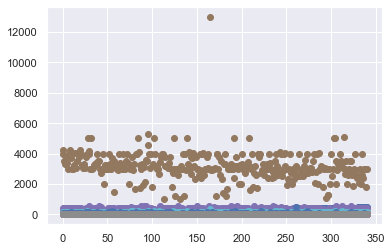

In [113]:
plt.plot(train_new,'o')
plt.show()

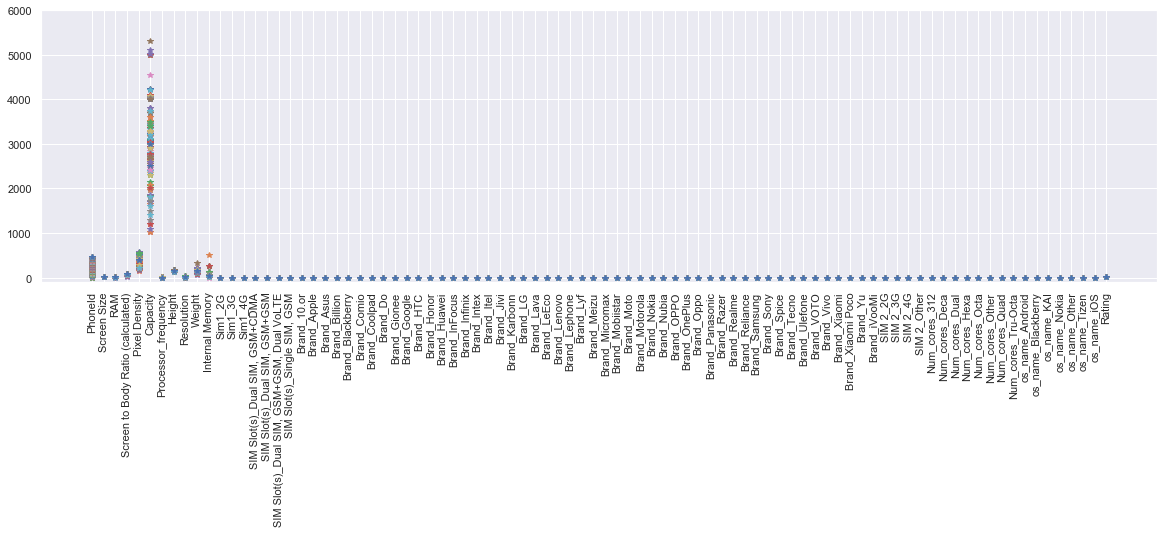

In [114]:
plt.figure(figsize=(20,5))
plt.plot(train_new.T,'*')
plt.ylim(-100,6000)
plt.xticks(rotation='vertical')
plt.show()

In [115]:
train_new['isLiked']=train_new['Rating'].map(lambda x: 0 if x<3.9 else 1)

In [116]:
print(train_new['isLiked'].value_counts())

1    267
0     74
Name: isLiked, dtype: int64


In [117]:
train_new.groupby('isLiked').mean()

PhoneId  Screen Size       RAM  Screen to Body Ratio (calculated)  Pixel Density     Capacity  Processor_frequency      Height  Resolution      Weight  Internal Memory   Sim1_2G   Sim1_3G   Sim1_4G  SIM Slot(s)_Dual SIM, GSM+CDMA  SIM Slot(s)_Dual SIM, GSM+GSM  SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE  SIM Slot(s)_Single SIM, GSM  Brand_10.or  Brand_Apple  Brand_Asus  Brand_Billion  Brand_Blackberry  Brand_Comio  Brand_Coolpad  Brand_Do  Brand_Gionee  Brand_Google  Brand_HTC  Brand_Honor  Brand_Huawei  Brand_InFocus  Brand_Infinix  Brand_Intex  Brand_Itel  Brand_Jivi  Brand_Karbonn  Brand_LG  Brand_Lava  Brand_LeEco  Brand_Lenovo  Brand_Lephone  Brand_Lyf  Brand_Meizu  Brand_Micromax  Brand_Mobiistar  Brand_Moto  Brand_Motorola  Brand_Nokia  Brand_Nubia  Brand_OPPO  Brand_OnePlus  Brand_Oppo  Brand_Panasonic  Brand_Razer  Brand_Realme  Brand_Reliance  Brand_Samsung  Brand_Sony  Brand_Spice  Brand_Tecno  Brand_Ulefone  Brand_VOTO  Brand_Vivo  Brand_Xiaomi  \
isLiked                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
0        311.189189     5.107432  2.513514                          68.329054     325.513514  2914.121622             1.551351  146.025383    6.932432  157.445946        26.162162  0.013514  0.054054  0.932432                        0.000000                       0.945946                                   0.000000                     0.054054     0.027027     0.000000    0.013514            0.0          0.040541     0.000000       0.013514       0.0      0.040541      0.000000   0.054054      0.00000      0.000000       0.027027       0.013514     0.040541    0.013514    0.013514       0.027027  0.054054    0.027027     0.000000      0.067568       0.013514   0.013514     0.000000        0.121622         0.027027    0.040541        0.000000     0.067568     0.013514    0.000000       0.000000    0.013514         0.027027     0.013514      0.000000        0.000000       0.054054    0.054054          0.0     0.000000       0.000000    0.013514    0.013514      0.000000   
1        211.292135     5.560674  3.438202                          73.468689     349.393258  3268.131086             1.859401  151.033116   10.329588  162.423221        51.970037  0.022472  0.011236  0.966292                        0.003745                       0.707865                                   0.194757                     0.093633     0.000000     0.071161    0.026217            0.0          0.007491     0.003745       0.003745       0.0      0.026217      0.014981   0.007491      0.06367      0.022472       0.003745       0.007491     0.003745    0.011236    0.000000       0.000000  0.018727    0.014981     0.003745      0.037453       0.000000   0.000000     0.007491        0.022472         0.007491    0.044944        0.007491     0.059925     0.000000    0.052434       0.011236    0.018727         0.007491     0.000000      0.014981        0.003745       0.149813    0.018727          0.0     0.029963       0.003745    0.000000    0.093633      0.078652   

         Brand_Xiaomi Poco  Brand_Yu  Brand_iVooMi  SIM 2_2G  SIM 2_3G 

In [118]:
X_train=train_new.drop('isLiked',axis=1)
X_train=X_train.drop('Rating',axis =1)

In [119]:
X_train.head()

PhoneId  Screen Size  RAM  Screen to Body Ratio (calculated)  Pixel Density  Capacity  Processor_frequency  Height  Resolution  Weight  Internal Memory  Sim1_2G  Sim1_3G  Sim1_4G  SIM Slot(s)_Dual SIM, GSM+CDMA  SIM Slot(s)_Dual SIM, GSM+GSM  SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE  SIM Slot(s)_Single SIM, GSM  Brand_10.or  Brand_Apple  Brand_Asus  Brand_Billion  Brand_Blackberry  Brand_Comio  Brand_Coolpad  Brand_Do  Brand_Gionee  Brand_Google  Brand_HTC  Brand_Honor  Brand_Huawei  Brand_InFocus  Brand_Infinix  Brand_Intex  Brand_Itel  Brand_Jivi  Brand_Karbonn  Brand_LG  Brand_Lava  Brand_LeEco  Brand_Lenovo  Brand_Lephone  Brand_Lyf  Brand_Meizu  Brand_Micromax  Brand_Mobiistar  Brand_Moto  Brand_Motorola  Brand_Nokia  Brand_Nubia  Brand_OPPO  Brand_OnePlus  Brand_Oppo  Brand_Panasonic  Brand_Razer  Brand_Realme  Brand_Reliance  Brand_Samsung  Brand_Sony  Brand_Spice  Brand_Tecno  Brand_Ulefone  Brand_VOTO  Brand_Vivo  Brand_Xiaomi  Brand_Xiaomi Poco  Brand_Yu  Brand_iVooMi  \
0        0         6.26    4                              80.68            403      4000                  1.8   157.9          20     182               64        0        0        1                               0                              0                                          1                            0            0            0           0              0                 0            0              0         0             0             0          0            0             0              0              0            0           0           0              0         0           0            0             0              0          0            0               0                0           0               0            0            0           0              0           0                0            0             0               0              0           0            0            0              0           0           0             1                  0         0             0   
1        1         6.20    3                              80.85            271      4230                  1.8   156.2           8     168               32        0        0        1                               0                              0                                          1                            0            0            0           0              0                 0            0              0         0             0             0          0            0             0              0              0            0           0           0              0         0           0            0             0              0          0            0               0                0           0               0            0            0           0              0           0                0            0             1               0              0           0            0            0              0           0           0             0                  0         0             0   
2        2         6.30    3                              83.68            409      3500                  2.1   157.0          25     168               32        0        0        1                               0                              0                                          1                            0            0            0           0              0                 0            0              0         0             0             0          0            0             0              0              0            0           0           0              0         0           0            0             0              0          0            0               0                0           0               0            0            0           0              0           0                0            0             1               0              0           0            0            0              0           0           0             0                  0         0             0   
3  

In [120]:
Y_train = train_new['isLiked']

In [121]:
print(X_train.shape)
print(Y_train.shape)

(341, 87)
(341,)


In [122]:
test_new.columns

Index(['PhoneId', 'Screen Size', 'RAM', 'Screen to Body Ratio (calculated)', 'Pixel Density', 'Capacity', 'Processor_frequency', 'Height', 'Resolution', 'Weight', 'Internal Memory', 'Sim1_2G', 'Sim1_3G', 'Sim1_4G', 'SIM Slot(s)_Dual SIM, GSM+CDMA', 'SIM Slot(s)_Dual SIM, GSM+GSM', 'SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE', 'SIM Slot(s)_Single SIM, GSM', 'Brand_10.or', 'Brand_Apple', 'Brand_Asus', 'Brand_Billion', 'Brand_Blackberry', 'Brand_Comio', 'Brand_Coolpad', 'Brand_Do', 'Brand_Gionee', 'Brand_Google', 'Brand_HTC', 'Brand_Honor', 'Brand_Huawei', 'Brand_InFocus', 'Brand_Infinix', 'Brand_Intex', 'Brand_Itel', 'Brand_Jivi', 'Brand_Karbonn', 'Brand_LG', 'Brand_Lava', 'Brand_LeEco', 'Brand_Lenovo', 'Brand_Lephone', 'Brand_Lyf', 'Brand_Meizu', 'Brand_Micromax', 'Brand_Mobiistar', 'Brand_Moto', 'Brand_Motorola', 'Brand_Nokia', 'Brand_Nubia', 'Brand_OPPO', 'Brand_OnePlus', 'Brand_Oppo', 'Brand_Panasonic', 'Brand_Razer', 'Brand_Realme', 'Brand_Reliance', 'Brand_Samsung', 'Brand_Sony',
  

In [123]:
X_test = test_new.copy()

In [124]:
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set()

In [125]:
X_binarised_train = X_train.drop('PhoneId',axis=1)

In [126]:
train_new.groupby('isLiked').mean()

PhoneId  Screen Size       RAM  Screen to Body Ratio (calculated)  Pixel Density     Capacity  Processor_frequency      Height  Resolution      Weight  Internal Memory   Sim1_2G   Sim1_3G   Sim1_4G  SIM Slot(s)_Dual SIM, GSM+CDMA  SIM Slot(s)_Dual SIM, GSM+GSM  SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE  SIM Slot(s)_Single SIM, GSM  Brand_10.or  Brand_Apple  Brand_Asus  Brand_Billion  Brand_Blackberry  Brand_Comio  Brand_Coolpad  Brand_Do  Brand_Gionee  Brand_Google  Brand_HTC  Brand_Honor  Brand_Huawei  Brand_InFocus  Brand_Infinix  Brand_Intex  Brand_Itel  Brand_Jivi  Brand_Karbonn  Brand_LG  Brand_Lava  Brand_LeEco  Brand_Lenovo  Brand_Lephone  Brand_Lyf  Brand_Meizu  Brand_Micromax  Brand_Mobiistar  Brand_Moto  Brand_Motorola  Brand_Nokia  Brand_Nubia  Brand_OPPO  Brand_OnePlus  Brand_Oppo  Brand_Panasonic  Brand_Razer  Brand_Realme  Brand_Reliance  Brand_Samsung  Brand_Sony  Brand_Spice  Brand_Tecno  Brand_Ulefone  Brand_VOTO  Brand_Vivo  Brand_Xiaomi  \
isLiked                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
0        311.189189     5.107432  2.513514                          68.329054     325.513514  2914.121622             1.551351  146.025383    6.932432  157.445946        26.162162  0.013514  0.054054  0.932432                        0.000000                       0.945946                                   0.000000                     0.054054     0.027027     0.000000    0.013514            0.0          0.040541     0.000000       0.013514       0.0      0.040541      0.000000   0.054054      0.00000      0.000000       0.027027       0.013514     0.040541    0.013514    0.013514       0.027027  0.054054    0.027027     0.000000      0.067568       0.013514   0.013514     0.000000        0.121622         0.027027    0.040541        0.000000     0.067568     0.013514    0.000000       0.000000    0.013514         0.027027     0.013514      0.000000        0.000000       0.054054    0.054054          0.0     0.000000       0.000000    0.013514    0.013514      0.000000   
1        211.292135     5.560674  3.438202                          73.468689     349.393258  3268.131086             1.859401  151.033116   10.329588  162.423221        51.970037  0.022472  0.011236  0.966292                        0.003745                       0.707865                                   0.194757                     0.093633     0.000000     0.071161    0.026217            0.0          0.007491     0.003745       0.003745       0.0      0.026217      0.014981   0.007491      0.06367      0.022472       0.003745       0.007491     0.003745    0.011236    0.000000       0.000000  0.018727    0.014981     0.003745      0.037453       0.000000   0.000000     0.007491        0.022472         0.007491    0.044944        0.007491     0.059925     0.000000    0.052434       0.011236    0.018727         0.007491     0.000000      0.014981        0.003745       0.149813    0.018727          0.0     0.029963       0.003745    0.000000    0.093633      0.078652   

         Brand_Xiaomi Poco  Brand_Yu  Brand_iVooMi  SIM 2_2G  SIM 2_3G 

In [127]:
train_new.head()

PhoneId  Screen Size  RAM  Screen to Body Ratio (calculated)  Pixel Density  Capacity  Processor_frequency  Height  Resolution  Weight  Internal Memory  Sim1_2G  Sim1_3G  Sim1_4G  SIM Slot(s)_Dual SIM, GSM+CDMA  SIM Slot(s)_Dual SIM, GSM+GSM  SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE  SIM Slot(s)_Single SIM, GSM  Brand_10.or  Brand_Apple  Brand_Asus  Brand_Billion  Brand_Blackberry  Brand_Comio  Brand_Coolpad  Brand_Do  Brand_Gionee  Brand_Google  Brand_HTC  Brand_Honor  Brand_Huawei  Brand_InFocus  Brand_Infinix  Brand_Intex  Brand_Itel  Brand_Jivi  Brand_Karbonn  Brand_LG  Brand_Lava  Brand_LeEco  Brand_Lenovo  Brand_Lephone  Brand_Lyf  Brand_Meizu  Brand_Micromax  Brand_Mobiistar  Brand_Moto  Brand_Motorola  Brand_Nokia  Brand_Nubia  Brand_OPPO  Brand_OnePlus  Brand_Oppo  Brand_Panasonic  Brand_Razer  Brand_Realme  Brand_Reliance  Brand_Samsung  Brand_Sony  Brand_Spice  Brand_Tecno  Brand_Ulefone  Brand_VOTO  Brand_Vivo  Brand_Xiaomi  Brand_Xiaomi Poco  Brand_Yu  Brand_iVooMi  \
0        0         6.26    4                              80.68            403      4000                  1.8   157.9          20     182               64        0        0        1                               0                              0                                          1                            0            0            0           0              0                 0            0              0         0             0             0          0            0             0              0              0            0           0           0              0         0           0            0             0              0          0            0               0                0           0               0            0            0           0              0           0                0            0             0               0              0           0            0            0              0           0           0             1                  0         0             0   
1        1         6.20    3                              80.85            271      4230                  1.8   156.2           8     168               32        0        0        1                               0                              0                                          1                            0            0            0           0              0                 0            0              0         0             0             0          0            0             0              0              0            0           0           0              0         0           0            0             0              0          0            0               0                0           0               0            0            0           0              0           0                0            0             1               0              0           0            0            0              0           0           0             0                  0         0             0   
2        2         6.30    3                              83.68            409      3500                  2.1   157.0          25     168               32        0        0        1                               0                              0                                          1                            0            0            0           0              0                 0            0              0         0             0             0          0            0             0              0              0            0           0           0              0         0           0            0             0              0          0            0               0                0           0               0            0            0           0              0           0                0            0             1               0              0           0            0            0              0           0           0             0                  0         0             0   
3  

In [128]:
X_binarised_train['Screen to Body Ratio (calculated)']=X_train['Screen to Body Ratio (calculated)'].map(lambda x: 0 if x<X_train['Screen to Body Ratio (calculated)'].mean() else 1)
X_binarised_train['Capacity']=X_train['Capacity'].map(lambda x: 0 if x<X_train['Capacity'].mean() else 1)
X_binarised_train['Pixel Density']=X_train['Pixel Density'].map(lambda x: 0 if x<X_train['Pixel Density'].mean() else 1)
X_binarised_train['Height']=X_train['Height'].map(lambda x: 0 if x<X_train['Height'].mean() else 1)
X_binarised_train['Processor_frequency']=X_train['Processor_frequency'].map(lambda x: 0 if x<X_train['Processor_frequency'].mean() else 1)

In [129]:
X_binarised_train['RAM']=X_train['RAM'].map(lambda x: 0 if x<X_train['RAM'].mean() else 1)
X_binarised_train['Internal Memory']=X_train['Internal Memory'].map(lambda x: 0 if x<X_train['Internal Memory'].mean() else 1)
X_binarised_train['Resolution']=X_train['Resolution'].map(lambda x: 0 if x<X_train['Resolution'].mean() else 1)
X_binarised_train['Weight']=X_train['Weight'].map(lambda x: 0 if x<X_train['Weight'].mean() else 1)
X_binarised_train['Screen Size']=X_train['Screen Size'].map(lambda x: 0 if x<X_train['Screen Size'].mean() else 1)

In [130]:
X_binarised_train.head()

Screen Size  RAM  Screen to Body Ratio (calculated)  Pixel Density  Capacity  Processor_frequency  Height  Resolution  Weight  Internal Memory  Sim1_2G  Sim1_3G  Sim1_4G  SIM Slot(s)_Dual SIM, GSM+CDMA  SIM Slot(s)_Dual SIM, GSM+GSM  SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE  SIM Slot(s)_Single SIM, GSM  Brand_10.or  Brand_Apple  Brand_Asus  Brand_Billion  Brand_Blackberry  Brand_Comio  Brand_Coolpad  Brand_Do  Brand_Gionee  Brand_Google  Brand_HTC  Brand_Honor  Brand_Huawei  Brand_InFocus  Brand_Infinix  Brand_Intex  Brand_Itel  Brand_Jivi  Brand_Karbonn  Brand_LG  Brand_Lava  Brand_LeEco  Brand_Lenovo  Brand_Lephone  Brand_Lyf  Brand_Meizu  Brand_Micromax  Brand_Mobiistar  Brand_Moto  Brand_Motorola  Brand_Nokia  Brand_Nubia  Brand_OPPO  Brand_OnePlus  Brand_Oppo  Brand_Panasonic  Brand_Razer  Brand_Realme  Brand_Reliance  Brand_Samsung  Brand_Sony  Brand_Spice  Brand_Tecno  Brand_Ulefone  Brand_VOTO  Brand_Vivo  Brand_Xiaomi  Brand_Xiaomi Poco  Brand_Yu  Brand_iVooMi  SIM 2_2G  \
0            1    1                                  1              1         1                    1       1           1       1                1        0        0        1                               0                              0                                          1                            0            0            0           0              0                 0            0              0         0             0             0          0            0             0              0              0            0           0           0              0         0           0            0             0              0          0            0               0                0           0               0            0            0           0              0           0                0            0             0               0              0           0            0            0              0           0           0             1                  0         0             0         0   
1            1    0                                  1              0         1                    1       1           0       1                0        0        0        1                               0                              0                                          1                            0            0            0           0              0                 0            0              0         0             0             0          0            0             0              0              0            0           0           0              0         0           0            0             0              0          0            0               0                0           0               0            0            0           0              0           0                0            0             1               0              0           0            0            0              0           0           0             0                  0         0             0         0   
2            1    0                                  1              1         1                    1       1           1       1                0        0        0        1                               0                              0                                          1                            0            0            0           0              0                 0            0              0         0             0             0          0            0             0              0              0            0           0           0              0         0           0            0             0              0          0            0               0                0           0               0            0            0           0              0           0                0            0             1               0              0           0            0            0              0           0           0             0                  0         0             0         0   

In [131]:
print(X_binarised_train.shape)
print(X_test.shape)

(341, 86)
(119, 87)


In [132]:
Train_PhoneId = train_new['PhoneId']
Test_PhoneId = X_test['PhoneId']
print(X_binarised_train.shape)
print(X_test.shape)

(341, 86)
(119, 87)


In [133]:
X_test.columns

Index(['PhoneId', 'Screen Size', 'RAM', 'Screen to Body Ratio (calculated)', 'Pixel Density', 'Capacity', 'Processor_frequency', 'Height', 'Resolution', 'Weight', 'Internal Memory', 'Sim1_2G', 'Sim1_3G', 'Sim1_4G', 'SIM Slot(s)_Dual SIM, GSM+CDMA', 'SIM Slot(s)_Dual SIM, GSM+GSM', 'SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE', 'SIM Slot(s)_Single SIM, GSM', 'Brand_10.or', 'Brand_Apple', 'Brand_Asus', 'Brand_Billion', 'Brand_Blackberry', 'Brand_Comio', 'Brand_Coolpad', 'Brand_Do', 'Brand_Gionee', 'Brand_Google', 'Brand_HTC', 'Brand_Honor', 'Brand_Huawei', 'Brand_InFocus', 'Brand_Infinix', 'Brand_Intex', 'Brand_Itel', 'Brand_Jivi', 'Brand_Karbonn', 'Brand_LG', 'Brand_Lava', 'Brand_LeEco', 'Brand_Lenovo', 'Brand_Lephone', 'Brand_Lyf', 'Brand_Meizu', 'Brand_Micromax', 'Brand_Mobiistar', 'Brand_Moto', 'Brand_Motorola', 'Brand_Nokia', 'Brand_Nubia', 'Brand_OPPO', 'Brand_OnePlus', 'Brand_Oppo', 'Brand_Panasonic', 'Brand_Razer', 'Brand_Realme', 'Brand_Reliance', 'Brand_Samsung', 'Brand_Sony',
  

Now time for binarsitaion of Test data

In [134]:
X_binarised_test=X_test.drop('PhoneId',axis=1)

In [135]:
X_binarised_test['Screen to Body Ratio (calculated)']=X_test['Screen to Body Ratio (calculated)'].map(lambda x: 0 if x<X_train['Screen to Body Ratio (calculated)'].mean() else 1)
X_binarised_test['Capacity']=X_test['Capacity'].map(lambda x: 0 if x<X_train['Capacity'].mean() else 1)
X_binarised_test['Pixel Density']=X_test['Pixel Density'].map(lambda x: 0 if x<X_train['Pixel Density'].mean() else 1)
X_binarised_test['Height']=X_test['Height'].map(lambda x: 0 if x<X_train['Height'].mean() else 1)
X_binarised_test['Processor_frequency']=X_test['Processor_frequency'].map(lambda x: 0 if x<X_train['Processor_frequency'].mean() else 1)
X_binarised_test['RAM']=X_test['RAM'].map(lambda x: 0 if x<X_train['RAM'].mean() else 1)
X_binarised_test['Internal Memory']=X_test['Internal Memory'].map(lambda x: 0 if x<X_train['Internal Memory'].mean() else 1)
X_binarised_test['Resolution']=X_test['Resolution'].map(lambda x: 0 if x<X_train['Resolution'].mean() else 1)
X_binarised_test['Weight']=X_test['Weight'].map(lambda x: 0 if x<X_train['Weight'].mean() else 1)
X_binarised_test['Screen Size']=X_test['Screen Size'].map(lambda x: 0 if x<X_train['Screen Size'].mean() else 1)

In [136]:
X_binarised_test.head()

Screen Size  RAM  Screen to Body Ratio (calculated)  Pixel Density  Capacity  Processor_frequency  Height  Resolution  Weight  Internal Memory  Sim1_2G  Sim1_3G  Sim1_4G  SIM Slot(s)_Dual SIM, GSM+CDMA  SIM Slot(s)_Dual SIM, GSM+GSM  SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE  SIM Slot(s)_Single SIM, GSM  Brand_10.or  Brand_Apple  Brand_Asus  Brand_Billion  Brand_Blackberry  Brand_Comio  Brand_Coolpad  Brand_Do  Brand_Gionee  Brand_Google  Brand_HTC  Brand_Honor  Brand_Huawei  Brand_InFocus  Brand_Infinix  Brand_Intex  Brand_Itel  Brand_Jivi  Brand_Karbonn  Brand_LG  Brand_Lava  Brand_LeEco  Brand_Lenovo  Brand_Lephone  Brand_Lyf  Brand_Meizu  Brand_Micromax  Brand_Mobiistar  Brand_Moto  Brand_Motorola  Brand_Nokia  Brand_Nubia  Brand_OPPO  Brand_OnePlus  Brand_Oppo  Brand_Panasonic  Brand_Razer  Brand_Realme  Brand_Reliance  Brand_Samsung  Brand_Sony  Brand_Spice  Brand_Tecno  Brand_Ulefone  Brand_VOTO  Brand_Vivo  Brand_Xiaomi  Brand_Xiaomi Poco  Brand_Yu  Brand_iVooMi  SIM 2_2G  \
0            1    0                                  1              0         1                    1       1           0       1                0        0        0        1                               0                              0                                          1                            0            0            0           0              0                 0            0              0         0             0             0          0            0             0              0              0            0           0           0              0         0           0            0             0              0          0            0               0                0           0               0            0            0           0              0           0                0            0             1               0              0           0            0            0              0           0           0             0                  0         0             0         0   
1            1    1                                  1              1         1                    1       1           1       1                1        0        0        1                               0                              0                                          1                            0            0            0           0              0                 0            0              0         0             0             0          0            0             0              0              0            0           0           0              0         0           0            0             0              0          0            0               0                0           0               1            0            0           0              0           0                0            0             0               0              0           0            0            0              0           0           0             0                  0         0             0         0   
2            1    1                                  1              1         1                    1       1           1       1                1        0        0        1                               0                              0                                          1                            0            0            0           0              0                 0            0              0         0             0             0          0            0             0              0              0            0           0           0              0         0           0            0             0              0          0            0               0                0           0               0            0            0           1              0           0                0            0             0               0              0           0            0            0              0           0           0             0                  0         0             0         0   

In [137]:
X_binarised_train =X_binarised_train.values

In [138]:
X_binarised_test =X_binarised_test.values

In [139]:
Y_train =Y_train.values

Data Ready to apply algorithm

# MP Neuron Class

In [140]:
class MPNeuron:
    def __init__(self):
        self.b = None

    def model(self, x):
        return 1 if (sum(x) >= self.b) else 0

    def predict(self, X):
        Y = []
        for x in X:
            result = self.model(x)
            Y.append(result)
        return np.array(Y)

    def fit(self, X, Y):
        accuracy = {}
        accuracy_s=[]
        
        for b in range(X.shape[1] + 1):
            self.b = b
            Y_pred = self.predict(X)
            accuracy[b] = accuracy_score(Y_pred, Y)
            accuracy_s.append(accuracy_score(Y_pred, Y))

        best_b = max(accuracy, key=accuracy.get)
        self.b = best_b
        plt.plot(range(0,X.shape[1]+1),accuracy_s)
        plt.show()
        print('Optimal value of b is', best_b)
        print('Highest accuracy is', accuracy[best_b])

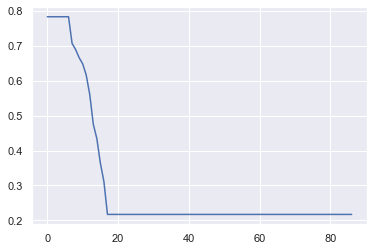

Optimal value of b is 0
Highest accuracy is 0.782991202346041


In [141]:
mp_neuron = MPNeuron()
mp_neuron.fit(X_binarised_train, Y_train)
Y_pred = mp_neuron.predict(X_binarised_train)

In [142]:
Y_pred2 = mp_neuron.predict(X_binarised_test)

In [143]:
submission = pd.DataFrame({'PhoneId':X_test['PhoneId'], 'Class':Y_pred2})
submission = submission[['PhoneId', 'Class']]
submission.describe()

PhoneId  Class
count  119.000000  119.0
mean   240.176471    1.0
std    136.804614    0.0
min      3.000000    1.0
25%    130.000000    1.0
50%    245.000000    1.0
75%    348.500000    1.0
max    473.000000    1.0

In [144]:
submission.to_csv("submission2.csv", index=False)